# 0.0 Imports

In [135]:
import numpy   as np
import pandas  as pd
import seaborn as sns
import re

import umap.umap_ as umap   # pip install umap-learn

from IPython.display import HTML
from matplotlib import pyplot as plt

from ydata_profiling import ProfileReport


from sklearn import cluster       as c
from sklearn import metrics       as m
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn.manifold import TSNE

from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer ## pip install yellowbrick

## 0.1. Helper Functions

In [64]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Load dataset

In [65]:
# load 

df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode_escape', low_memory= False)

df_raw = df_raw.drop( columns= ['Unnamed: 8'], axis = 1)
df_raw.head()

InvoiceNo StockCode                          Description  Quantity InvoiceDate  UnitPrice  CustomerID         Country
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   29-Nov-16       2.55     17850.0  United Kingdom
1    536365     71053                  WHITE METAL LANTERN         6   29-Nov-16       3.39     17850.0  United Kingdom
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   29-Nov-16       2.75     17850.0  United Kingdom
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   29-Nov-16       3.39     17850.0  United Kingdom
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   29-Nov-16       3.39     17850.0  United Kingdom

# <font color='red'> 1.0. Descrição dos dados </font>

In [66]:
df1 = df_raw.copy()

## 1.1. Rename columns 

In [67]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [68]:
cols_new = ['invoice_no', 'stock_code', 'description','quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data dimensions 

In [69]:
print( 'Number of rows: {}'.format (df1.shape[0]))
print( 'Number of columns: {}'.format (df1.shape[1]))

Number of rows: 541909
Number of columns: 8


## 1.3. Data types

In [70]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [71]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [72]:
df_missing = df1.loc[df1['customer_id'].isna(),:]
df_not_missing = df1.loc[~df1['customer_id'].isna(),:]


df_missing.shape, df_not_missing.shape

((135080, 8), (406829, 8))

In [73]:
# create reference 

df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000,19000+len(df_backup),1)

#merge original with reference dataframe 
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

#coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

#drop extra columns 

df1 = df1.drop(columns= ['customer_id_x', 'customer_id_y'], axis=1)
df1.head(25)

invoice_no stock_code                          description  quantity invoice_date  unit_price         country  customer_id
0      536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6    29-Nov-16        2.55  United Kingdom      17850.0
1      536365      71053                  WHITE METAL LANTERN         6    29-Nov-16        3.39  United Kingdom      17850.0
2      536365     84406B       CREAM CUPID HEARTS COAT HANGER         8    29-Nov-16        2.75  United Kingdom      17850.0
3      536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6    29-Nov-16        3.39  United Kingdom      17850.0
4      536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6    29-Nov-16        3.39  United Kingdom      17850.0
5      536365      22752         SET 7 BABUSHKA NESTING BOXES         2    29-Nov-16        7.65  United Kingdom      17850.0
6      536365      21730    GLASS STAR FROSTED T-LIGHT HOLDER         6    29-Nov-16        4.25  United Kingdom      17850.0
7      536366      22633               HAND WARMER UNION JACK         6    29-Nov-16        1.85  United Kingdom      17850.0
8      536366      22632            HAND WARMER RED POLKA DOT         6    29-Nov-16        1.85  United Kingdom      17850.0
9      536367      84879        ASSORTED COLOUR BIRD ORNAMENT        32    29-Nov-16        1.69  United Kingdom      13047.0
10     536367      22745           POPPY'S PLAYHOUSE BEDROOM          6    29-Nov-16        2.10  United Kingdom      13047.0
11     536367      22748            POPPY'S PLAYHOUSE KITCHEN         6    29-Nov-16        2.10  United Kingdom      13047.0
12     536367      22749    FELTCRAFT PRINCESS CHARLOTTE DOLL         8    29-Nov-16        3.75  United Kingdom      13047.0
13     536367      22310              IVORY KNITTED MUG COSY          6    29-Nov-16        1.65  United Kingdom      13047.0
14     536367      84969   BOX OF 6 ASSORTED COLOUR TEASPOONS         6    29-Nov-16        4.25  United Kingdom      13047.0
15     536367      22623        BOX OF VINTAGE JIGSAW BLOCKS          3    29-Nov-16        4.95  United Kingdom      13047.0
16     536367      22622       BOX OF VINTAGE ALPHABET BLOCKS         2    29-Nov-16        9.95  United Kingdom      13047.0
17     536367      21754             HOME BUILDING BLOCK WORD         3    29-Nov-16        5.95  United Kingdom      13047.0
18     536367      21755             LOVE BUILDING BLOCK WORD         3    29-Nov-16        5.95  United Kingdom      13047.0
19     536367      21777          RECIPE BOX WITH METAL HEART         4    29-Nov-16        7.95  United Kingdom      13047.0
20     536367      48187                  DOORMAT NEW ENGLAND         4    29-Nov-16        7.95  United Kingdom      13047.0
21     536368      22960             JAM MAKING SET WITH JARS         6    29-Nov-16        4.25  United Kingdom      13047.0
22     536368      22913          RED COAT RACK PARIS FASHION         3    29-Nov-16        4.95  United Kingdom      13047.0
23     536368      22912       YELLOW COAT RACK PARIS FASHION         3    29-Nov-16        4.95  United Kingdom      13047.0
24     536368      22914         BLUE COAT RACK PARIS FASHION         3    29-Nov-16        4.95  United Kingdom      13047.0

In [74]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change dtypes

In [75]:
df1.head()

invoice_no stock_code                          description  quantity invoice_date  unit_price         country  customer_id
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6    29-Nov-16        2.55  United Kingdom      17850.0
1     536365      71053                  WHITE METAL LANTERN         6    29-Nov-16        3.39  United Kingdom      17850.0
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8    29-Nov-16        2.75  United Kingdom      17850.0
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6    29-Nov-16        3.39  United Kingdom      17850.0
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6    29-Nov-16        3.39  United Kingdom      17850.0

In [76]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int64 )
df1.head()

invoice_no stock_code                          description  quantity invoice_date  unit_price         country  customer_id
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   2016-11-29        2.55  United Kingdom        17850
1     536365      71053                  WHITE METAL LANTERN         6   2016-11-29        3.39  United Kingdom        17850
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   2016-11-29        2.75  United Kingdom        17850
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   2016-11-29        3.39  United Kingdom        17850
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   2016-11-29        3.39  United Kingdom        17850

## 1.7 Descriptive Statistics


In [77]:
num_attributes = df1.select_dtypes ( include=['int64','float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributs

In [78]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

attributes       min      max      range          mean   mediana          std        skew       kurtosis
0     quantity -80995.00  80995.0  161990.00      9.552250      3.00   218.080957   -0.264076  119769.160031
1   unit_price -11062.06  38970.0   50032.06      4.611114      2.08    96.759764  186.506972   59005.719097
2  customer_id  12346.00  22709.0   10363.00  16688.840453  16249.00  2911.408666    0.487449      -0.804287

### 1.7.1.1. Numerical Attributs - Investigating

Quantity negativa ( pode ser devolução )

Preço unitário igual a zero ( pode ser promoção? )

### 1.7.2. Categorical Attributs

In [79]:
cat_attributes.head()

invoice_no stock_code                          description         country
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER  United Kingdom
1     536365      71053                  WHITE METAL LANTERN  United Kingdom
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER  United Kingdom
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE  United Kingdom
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.  United Kingdom

####  Invoice No

In [80]:
# problema: Temos invoice com letras e numeros
#df1['invoice_no'].astype( int )

# identficacao: 
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
df_letter_invoices.head()

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
# todos os invoice_no que estão com sujeira com letra o quantity é menor que 0 ou seja valores em negativo s
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices: 9291
Total number of negative quantity: 9288


#### Stock Code

In [81]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()  #pega apenas texto em coluna de valores

# Acão:
## 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Country

In [82]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [83]:
df1['country'].value_counts( normalize=True).head()

country
United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: proportion, dtype: float64

In [84]:
df1[['customer_id', 'country']].drop_duplicates().groupby( 'country').count().reset_index().sort_values('customer_id', ascending=False).head()

country  customer_id
36  United Kingdom         7587
14         Germany           95
13          France           90
10            EIRE           44
31           Spain           31

# <font color='red'> 2.0. Filtragem de Variaveis </font>

In [85]:
df2 = df1.copy()

In [86]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

In [87]:
# === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK'])] # todos os valores diferentes do in 
# description
df2 = df2.drop( columns='description', axis=1 )

# map 
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ] # como vou trabalhar com lat e log eu não vou ter relacionamento com os dois valores

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] )] 

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

# <font color='red'> 3.0. Feature Engineering </font>

In [88]:
df3= df2.copy()

## 3.1. Feature Creation

In [89]:
df3.head()

invoice_no stock_code  quantity invoice_date  unit_price         country  customer_id
0     536365     85123A         6   2016-11-29        2.55  United Kingdom        17850
1     536365      71053         6   2016-11-29        3.39  United Kingdom        17850
2     536365     84406B         8   2016-11-29        2.75  United Kingdom        17850
3     536365     84029G         6   2016-11-29        3.39  United Kingdom        17850
4     536365     84029E         6   2016-11-29        3.39  United Kingdom        17850

In [90]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )

### 3.1.1. Gross Revenue

In [91]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

C:\Users\yvesl\AppData\Local\Temp\ipykernel_29196\206990356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency - Day from last purchase

In [92]:
# Recency - Last day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3 Quantity of purchased

In [93]:
# number of products
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id' ).count().reset_index().rename( columns={'invoice_no': 'qtde_invoices'}))
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

### 3.1.4.Quantity total of items purchased

In [94]:
# number of products
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].drop_duplicates().groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity': 'qtde_item'}))
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_item        91
dtype: int64

### 3.1.4.Quantity of products purchased

In [95]:
# number of products
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].drop_duplicates().groupby( 'customer_id' ).count().reset_index().rename( columns={'stock_code': 'qtde_products'}))
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_item        91
qtde_products    91
dtype: int64

### 3.1.5. Average Ticket Value

In [96]:
# Avg Ticket
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_item        91
qtde_products    91
avg_ticket       91
dtype: int64

### 3.1.6. Average Recency Days

In [97]:
# Average recency days 
df_aux = df2[['customer_id','invoice_date']].drop_duplicates().sort_values(['customer_id','invoice_date'], ascending=[False, False])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() #next invoince date

df_aux['avg_recency_days'] = df_aux.apply ( lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id']  else np.nan, axis=1 )

df_aux = df_aux.drop(['invoice_date','next_customer_id','previous_date'], axis=1).dropna()

# average recency
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge(df_ref,df_avg_recency_days, on='customer_id', how='left')

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_item             91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.7. Frequency Purchase

In [98]:
df_aux = ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_item             91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

### 3.1.8. Number of Returns

In [99]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_item             91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

### 3.1.9 Basket Size - Quantidade de Items por Cesta ( Quantity)
- Invoice No = Compra = purchase
- Stock Code  Produto = product
- Quantity = item = Item

In [101]:
df_aux = ( df2_purchases.loc[:,['customer_id', 'invoice_no', 'quantity']].groupby('customer_id').agg(n_purchase=('invoice_no', 'nunique'),n_products=( 'quantity','sum')).reset_index())

# calculation 
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge 
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_item             91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

### 3.2.0 Unique Basket Size - Quantidade de produtos distintos por compra
- Invoice No = Compra = purchase
- Stock Code  Produto = product
- Quantity = item = Item

In [102]:
df_aux = ( df2_purchases.loc[:,['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id').agg(n_purchase=('invoice_no', 'nunique'),n_products=( 'stock_code','nunique')).reset_index())

# calculation 
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge 
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_item                   91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

In [103]:
df_ref.head()

customer_id  gross_revenue  recency_days  qtde_invoices  qtde_item  qtde_products  avg_ticket  avg_recency_days  frequency  qtde_returns  avg_basket_size  avg_unique_basket_size
0        17850        5391.21         372.0           34.0       35.0           21.0   18.152222        -35.500000  17.000000          40.0        50.970588                8.735294
1        13047        3232.59          56.0            9.0      131.0          105.0   18.904035        -27.250000   0.028302          35.0       154.444444               19.000000
2        12583        6705.38           2.0           15.0     1568.0          114.0   28.902500        -23.187500   0.040323          50.0       335.200000               15.466667
3        13748         948.25          95.0            5.0      169.0           24.0   33.866071        -92.666667   0.017921           0.0        87.800000                5.600000
4        15100         876.00         333.0            3.0       48.0            1.0  292.000000         -8.600000   0.073171          22.0        26.666667                1.000000

# <font color='red'> 4.0. EDA </font>

In [104]:
df4 = df_ref.dropna().copy()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_item                 0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1 Univariate Analysis

**Notes**
1. Clusters coesos - separados
2. Métricas
    - Min, Máximos, Range ( dispersão)
    - Média e Mediana
    - Desvio Padrão e Variação
    - Coeficiente de Variação ( CV ) - tem que ficar maior que 1 para conseguir clusterizar 
    - Distribuição

In [105]:
profile = ProfileReport (df4)
profile.to_file('output.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


### 4.1.1 Gross Revenue

In [106]:
df4.sort_values('gross_revenue', ascending=False).head(10)

customer_id  gross_revenue  recency_days  qtde_invoices  qtde_item  qtde_products    avg_ticket  avg_recency_days  frequency  qtde_returns  avg_basket_size  avg_unique_basket_size
1017        14646      279138.02           1.0           72.0    15837.0          699.0    135.503893         -7.844444   0.203390         288.0      2733.944444               28.611111
492         18102      259657.30           0.0           60.0    12872.0          150.0    602.453132        -14.680000   0.163043           0.0      1068.733333                7.183333
433         17450      194550.79           8.0           46.0    38639.0          124.0    577.302047        -12.821429   0.127778         952.0      1521.586957                7.326087
3338        16446      168472.50           0.0            2.0    80996.0            3.0  56157.500000       -205.000000   0.009709       80995.0     40498.500000                1.500000
66          14911      140450.72           1.0          199.0     4247.0         1786.0     24.757751         -2.601399   0.533512        3332.0       403.331658               28.507538
1150        12415      124564.53          24.0           20.0     9932.0          443.0    174.704811        -20.866667   0.063694         427.0      3868.650000               35.650000
190         14156      117379.63           9.0           55.0     9208.0          714.0     83.842593         -7.260000   0.151515         859.0      1052.454545               25.454545
15          17511       91062.38           2.0           31.0     4375.0          453.0     94.561142        -11.593750   0.083333        1535.0      2082.225806               31.064516
12          16029       72882.09          38.0           62.0    10827.0           43.0    302.415311         -9.054054   0.184524        8004.0       648.500000                3.887097
955         16684       66653.56           4.0           28.0     8377.0          119.0    240.626570        -22.125000   0.078873         864.0      1794.821429                9.892857

## 4.2 Bivariate Analysis

In [112]:
cols = ['customer_id']
df42 = df4.drop( cols, axis=1 )

<Figure size 2500x1200 with 0 Axes>

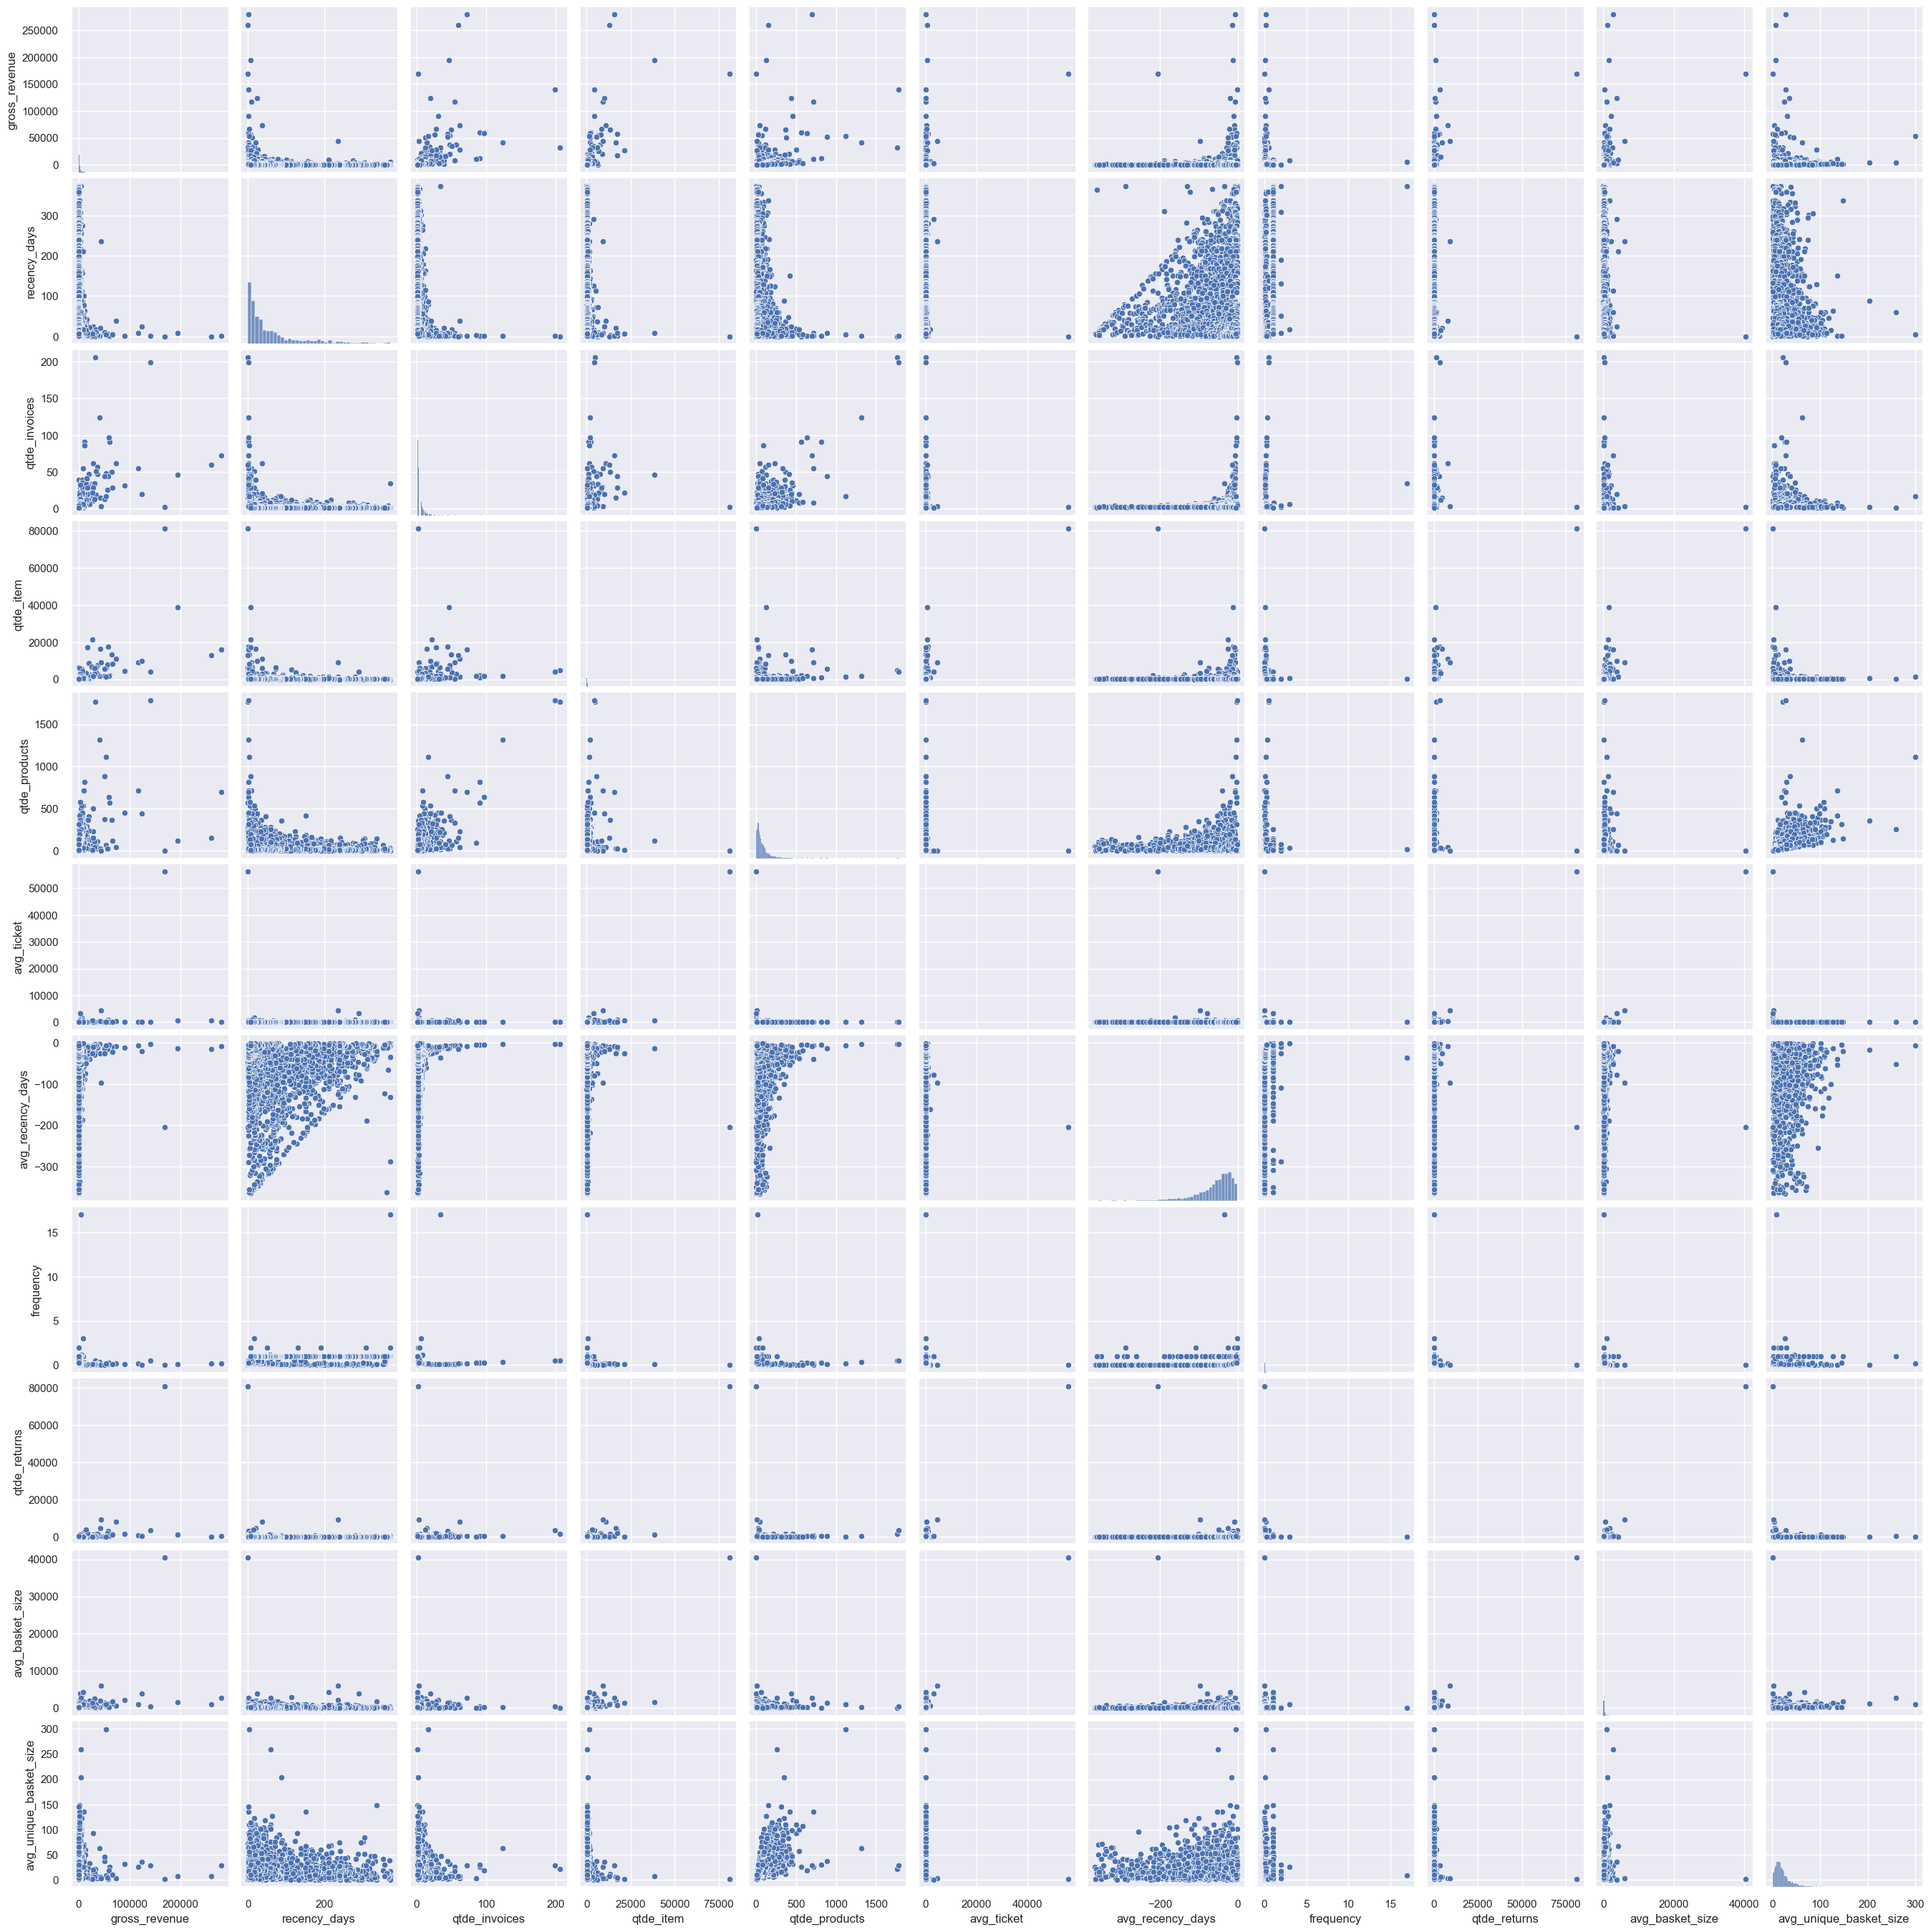

In [113]:
plt.figure(figsize=(25,12))
sns.pairplot(df42)


## 4.3. Estudo do Espaço

In [118]:
df43 = df4.drop( columns=['customer_id'], axis=1).copy()   

In [122]:
from sklearn import preprocessing as pp
mm = pp.MinMaxScaler()

In [123]:
df43['gross_revenue'] = mm.fit_transform( df43[['gross_revenue']] )
df43['recency_days'] = mm.fit_transform( df43[['recency_days']] )
df43['qtde_invoices'] = mm.fit_transform( df43[['qtde_invoices']] )
df43['qtde_item'] = mm.fit_transform( df43[['qtde_item']] )
df43['qtde_products'] = mm.fit_transform( df43[['qtde_products']] )
df43['avg_ticket'] = mm.fit_transform( df43[['avg_ticket']] )
df43['avg_recency_days'] = mm.fit_transform( df43[['avg_recency_days']] )
df43['frequency'] = mm.fit_transform( df43[['frequency']] )
df43['qtde_returns'] = mm.fit_transform( df43[['qtde_returns']] )
df43['avg_basket_size'] = mm.fit_transform( df43[['avg_basket_size']] )
df43['avg_unique_basket_size'] = mm.fit_transform( df43[['avg_unique_basket_size']] )

In [ ]:
verificar o codigo

qtde_item
qtde_products
avg_recency_days
avg_unique_basket_size

In [125]:
X = df43.copy()

### 4.3.1. PCA

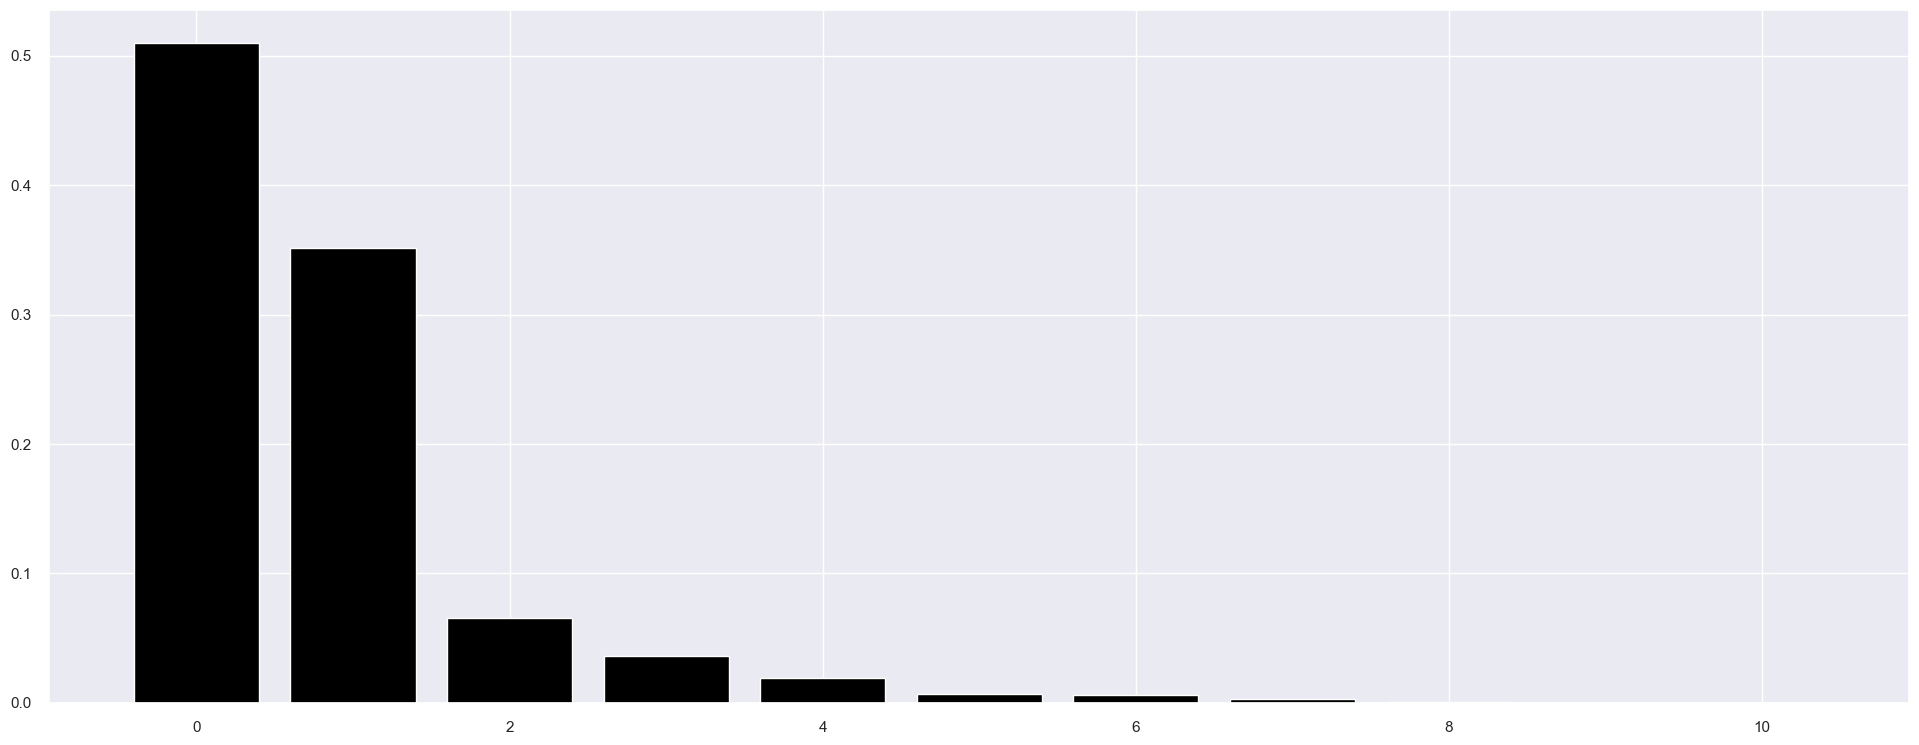

In [131]:

pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )
plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca compopnents
df_pca = pd.DataFrame( principal_components )

In [132]:
df_pca.head()

0         1         2         3         4         5         6         7         8         9         10
0  0.857134 -0.023361  0.048865  0.133922 -0.045785 -0.236110  0.934335 -0.105581  0.012737 -0.005620 -0.002154
1 -0.011072 -0.113118 -0.004206  0.008822 -0.010052  0.005904 -0.004987  0.000017 -0.002311 -0.000953 -0.000056
2 -0.154575 -0.142305 -0.016223  0.035312 -0.006230  0.002386  0.001932  0.011382  0.007126  0.002311 -0.000361
3  0.078024  0.079879 -0.051440  0.021040 -0.011106  0.003834 -0.005923  0.001179 -0.000765 -0.000833 -0.000245
4  0.736756 -0.079617 -0.026667  0.034662 -0.011844  0.012579 -0.027167  0.001323 -0.002351 -0.003525 -0.003529

<Axes: xlabel='0', ylabel='1'>

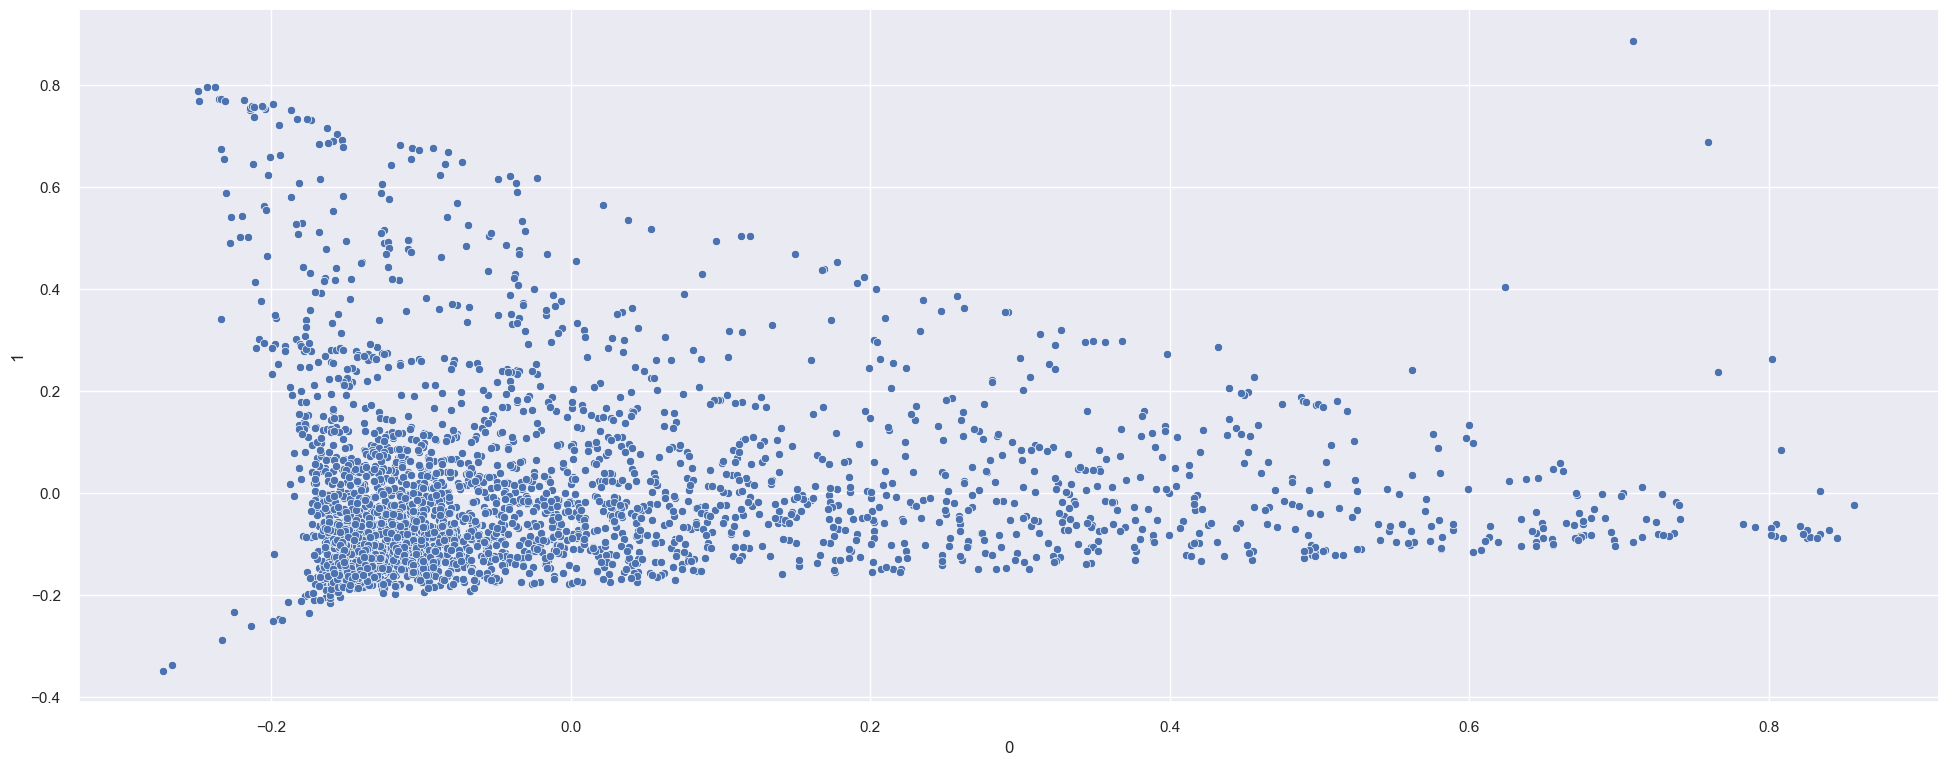

In [133]:
sns.scatterplot( x=0, y=1, data=df_pca )

### 4.3.2. UMAP

c:\Users\yvesl\.conda\envs\fidelity_program\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

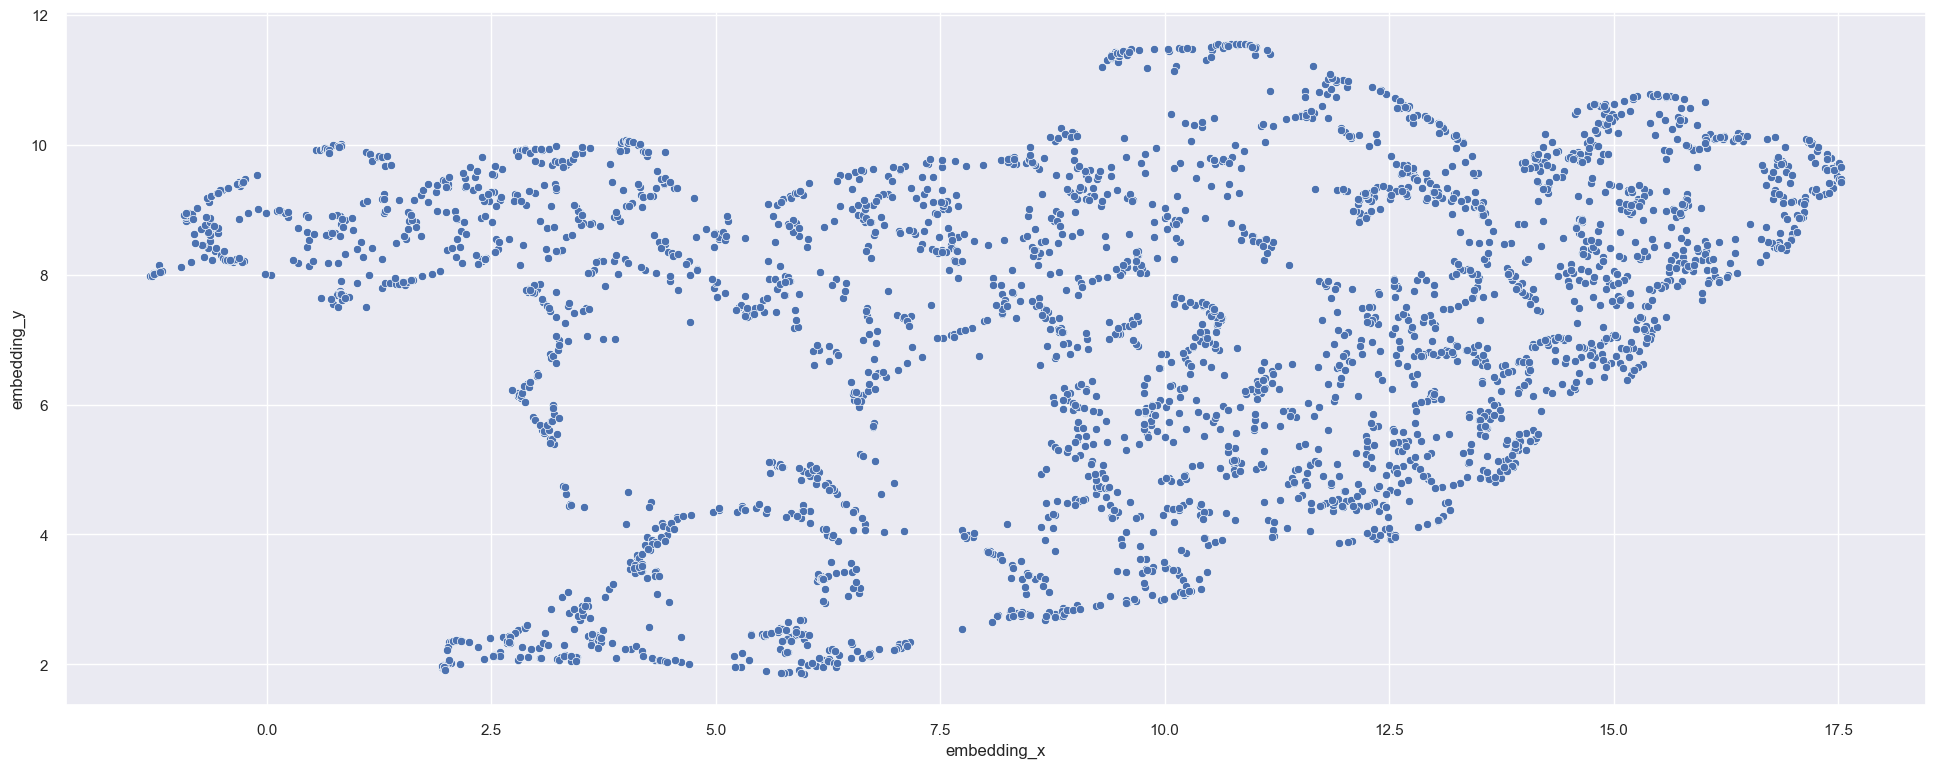

In [134]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 data=df_pca )

### 4.3.3. t-SNE

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

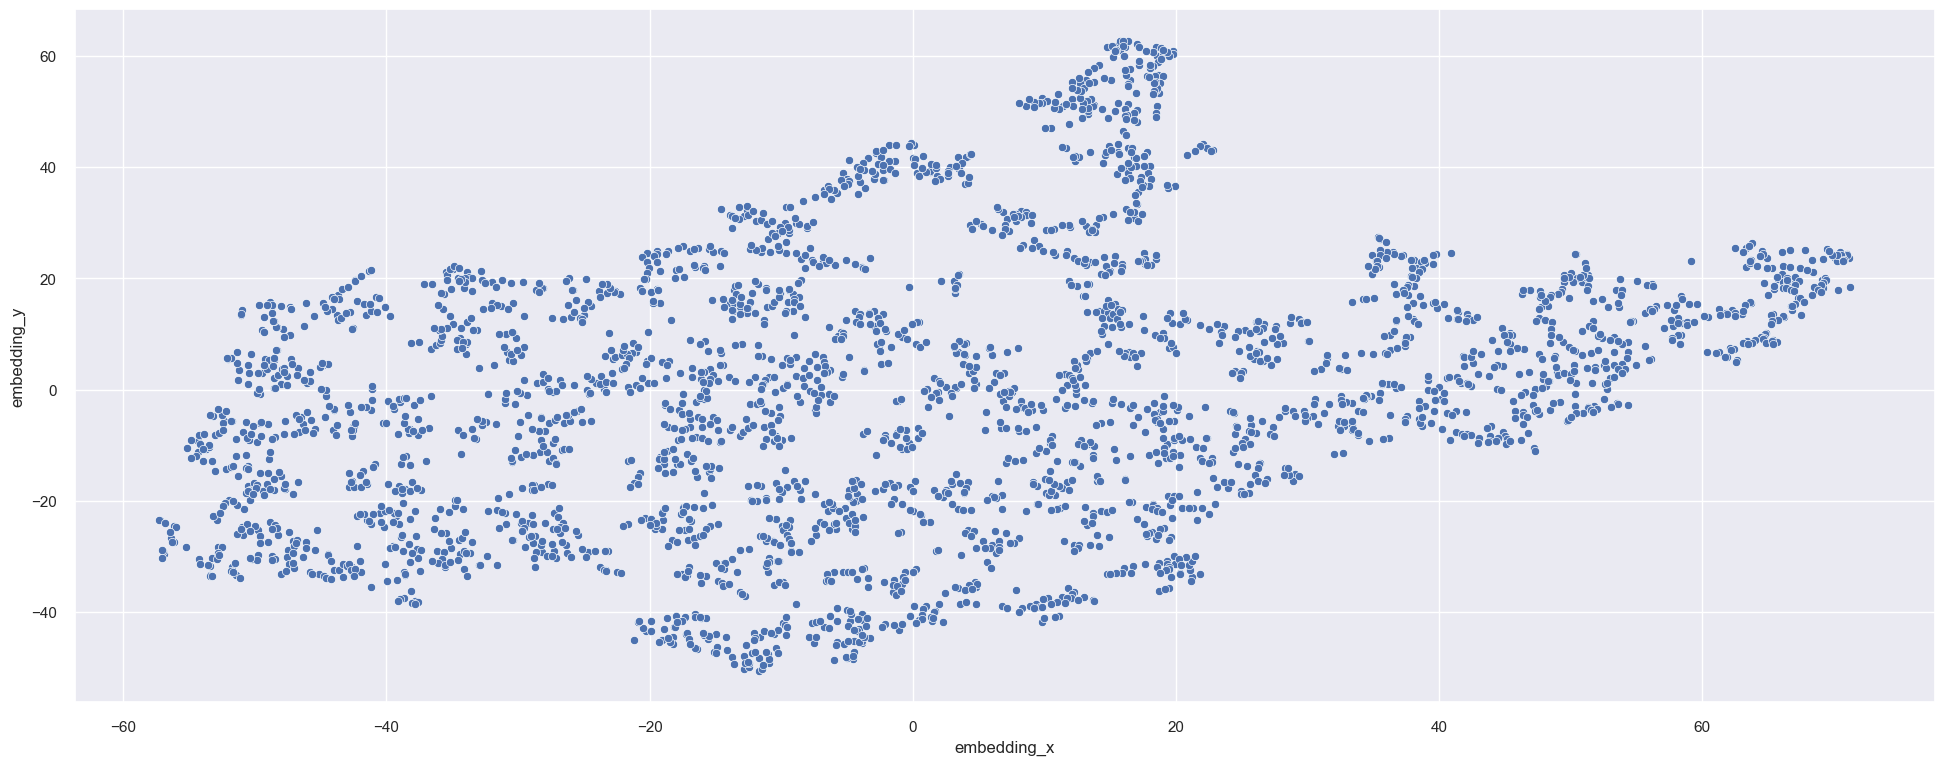

In [137]:
reducer = TSNE( n_components=2,
                    n_jobs=-1,
                    random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 data=df_pca )

### 4.3.4. Tree-Based Embedding

In [140]:
from sklearn import ensemble as en

In [141]:
# training dataset  
from random import Random


X = df4.drop( columns=['customer_id','gross_revenue'], axis=1 )
y = df4['gross_revenue']

# model definition 
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )


# model training 
rf_model.fit( X, y )



# leaf


# dataframe leaf


RandomForestRegressor(random_state=42)

In [143]:
df_leat = pd.DataFrame( rf_model.apply( X ) )

In [144]:
df_leat.shape

(2969, 100)

c:\Users\yvesl\.conda\envs\fidelity_program\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

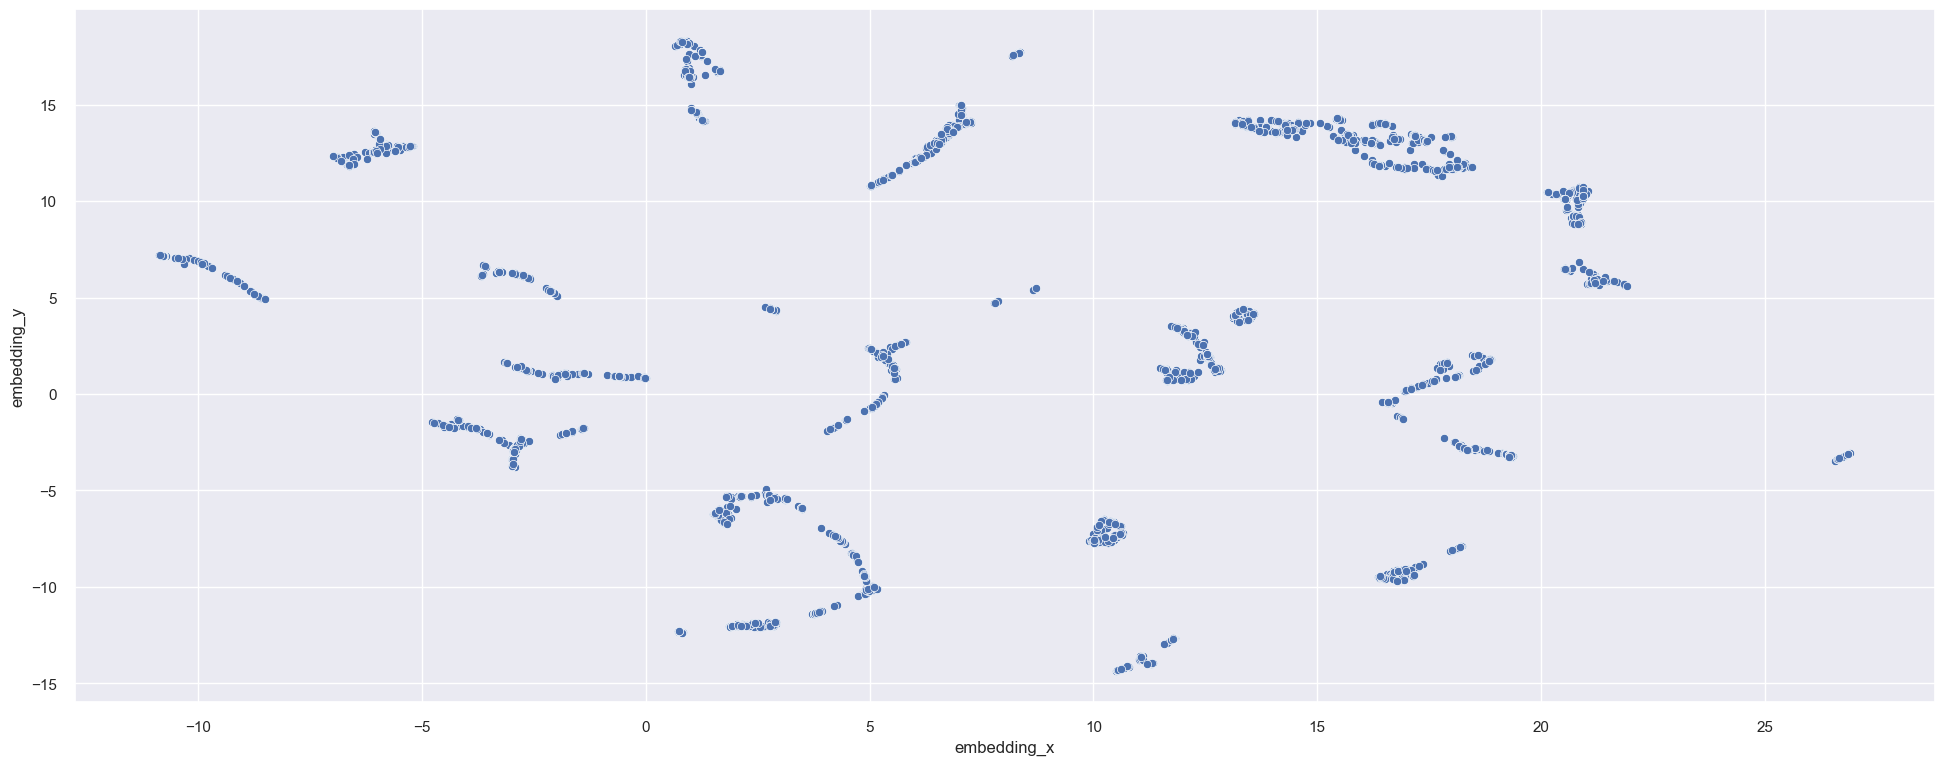

In [145]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leat )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 data=df_pca )

In [146]:
df_pca.head()

0         1         2         3         4         5         6         7         8         9        10  embedding_x  embedding_y
0  0.857134 -0.023361  0.048865  0.133922 -0.045785 -0.236110  0.934335 -0.105581  0.012737 -0.005620 -0.002154    -4.201092    -1.318624
1 -0.011072 -0.113118 -0.004206  0.008822 -0.010052  0.005904 -0.004987  0.000017 -0.002311 -0.000953 -0.000056     2.156639   -11.953190
2 -0.154575 -0.142305 -0.016223  0.035312 -0.006230  0.002386  0.001932  0.011382  0.007126  0.002311 -0.000361    -2.779743    -2.528642
3  0.078024  0.079879 -0.051440  0.021040 -0.011106  0.003834 -0.005923  0.001179 -0.000765 -0.000833 -0.000245     6.997683    14.230053
4  0.736756 -0.079617 -0.026667  0.034662 -0.011844  0.012579 -0.027167  0.001323 -0.002351 -0.003525 -0.003529    -6.001510    12.518351

# <font color='red'> 5.0. Data Preparation </font>

In [152]:
df5 = df4.copy()

In [153]:
## Standard Scalaer
ss = pp.MinMaxScaler()
# ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform( df5[['gross_revenue']] )
df5['recency_days'] = ss.fit_transform( df5[['recency_days']] )
df5['qtde_invoices'] = ss.fit_transform( df5[['qtde_invoices']] )
df5['qtde_item'] = ss.fit_transform( df5[['qtde_item']] )
df5['qtde_products'] = ss.fit_transform( df5[['qtde_products']] )
df5['avg_ticket'] = ss.fit_transform( df5[['avg_ticket']] )
df5['avg_recency_days'] = ss.fit_transform( df5[['avg_recency_days']] )
df5['frequency'] = ss.fit_transform( df5[['frequency']] )
df5['qtde_returns'] = ss.fit_transform( df5[['qtde_returns']] )
df5['avg_basket_size'] = ss.fit_transform( df5[['avg_basket_size']] )
df5['avg_unique_basket_size'] = ss.fit_transform( df5[['avg_unique_basket_size']] )


In [154]:
df5.head()

customer_id  gross_revenue  recency_days  qtde_invoices  qtde_item  qtde_products  avg_ticket  avg_recency_days  frequency  qtde_returns  avg_basket_size  avg_unique_basket_size
0        17850       0.019292      0.997319       0.160976   0.000420       0.011204    0.000285          0.905479   1.000000      0.000494         0.001234                0.025896
1        13047       0.011559      0.150134       0.039024   0.001605       0.058263    0.000298          0.928082   0.001345      0.000432         0.003789                0.060260
2        12583       0.024000      0.005362       0.068293   0.019347       0.063305    0.000476          0.939212   0.002052      0.000617         0.008252                0.048431
3        13748       0.003375      0.254692       0.019512   0.002074       0.012885    0.000565          0.748858   0.000734      0.000000         0.002143                0.015400
4        15100       0.003116      0.892761       0.009756   0.000580       0.000000    0.005162          0.979178   0.003985      0.000272         0.000634                0.000000

# <font color='red'> 6.0. Feature Selection </font>

In [155]:
df6 = df5.copy()

# <font color='red'> 7.0. Hyperparameter Fine-Tunning</font>

In [156]:
X = df6.drop( columns=['customer_id'])

In [157]:
clusters = [2,3,4,5,6,7]

## 7.1. Within-Clusteer Sum of Square (WSS)

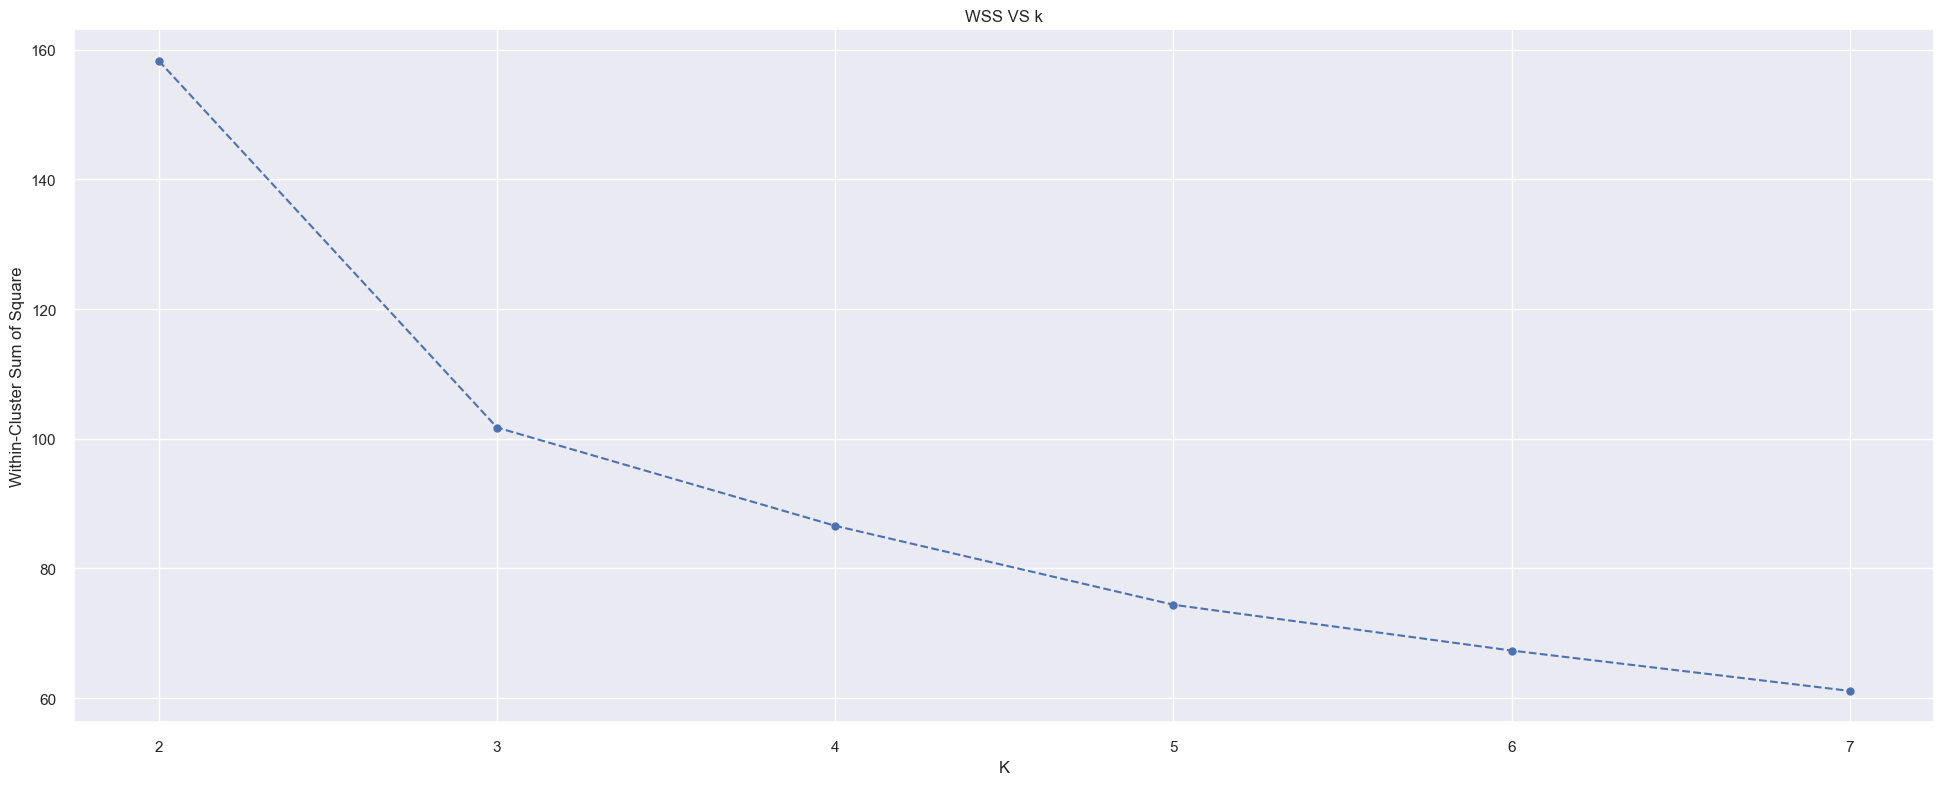

In [158]:
wss = []
for k in clusters:
    # model definition  
    kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300 )
    # model training 
    kmeans.fit( X )
    # validation 
    wss.append(kmeans.inertia_)
    
# plot wss - ELBOW METHOD 
# tenho que escolher o lugar que o ponto mais se desloca e testar para saber o cluster para utilizar nesse exemplo foi 3 e 5
plt.plot (clusters, wss,linestyle='--', marker='o', color='b')
plt.xlabel ( 'K');
plt.ylabel ( 'Within-Cluster Sum of Square')
plt.title( 'WSS VS k');

c:\Users\yvesl\.conda\envs\fidelity_program\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\yvesl\.conda\envs\fidelity_program\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\yvesl\.conda\envs\fidelity_program\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\yvesl\.conda\envs\fidelity_program\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The defa

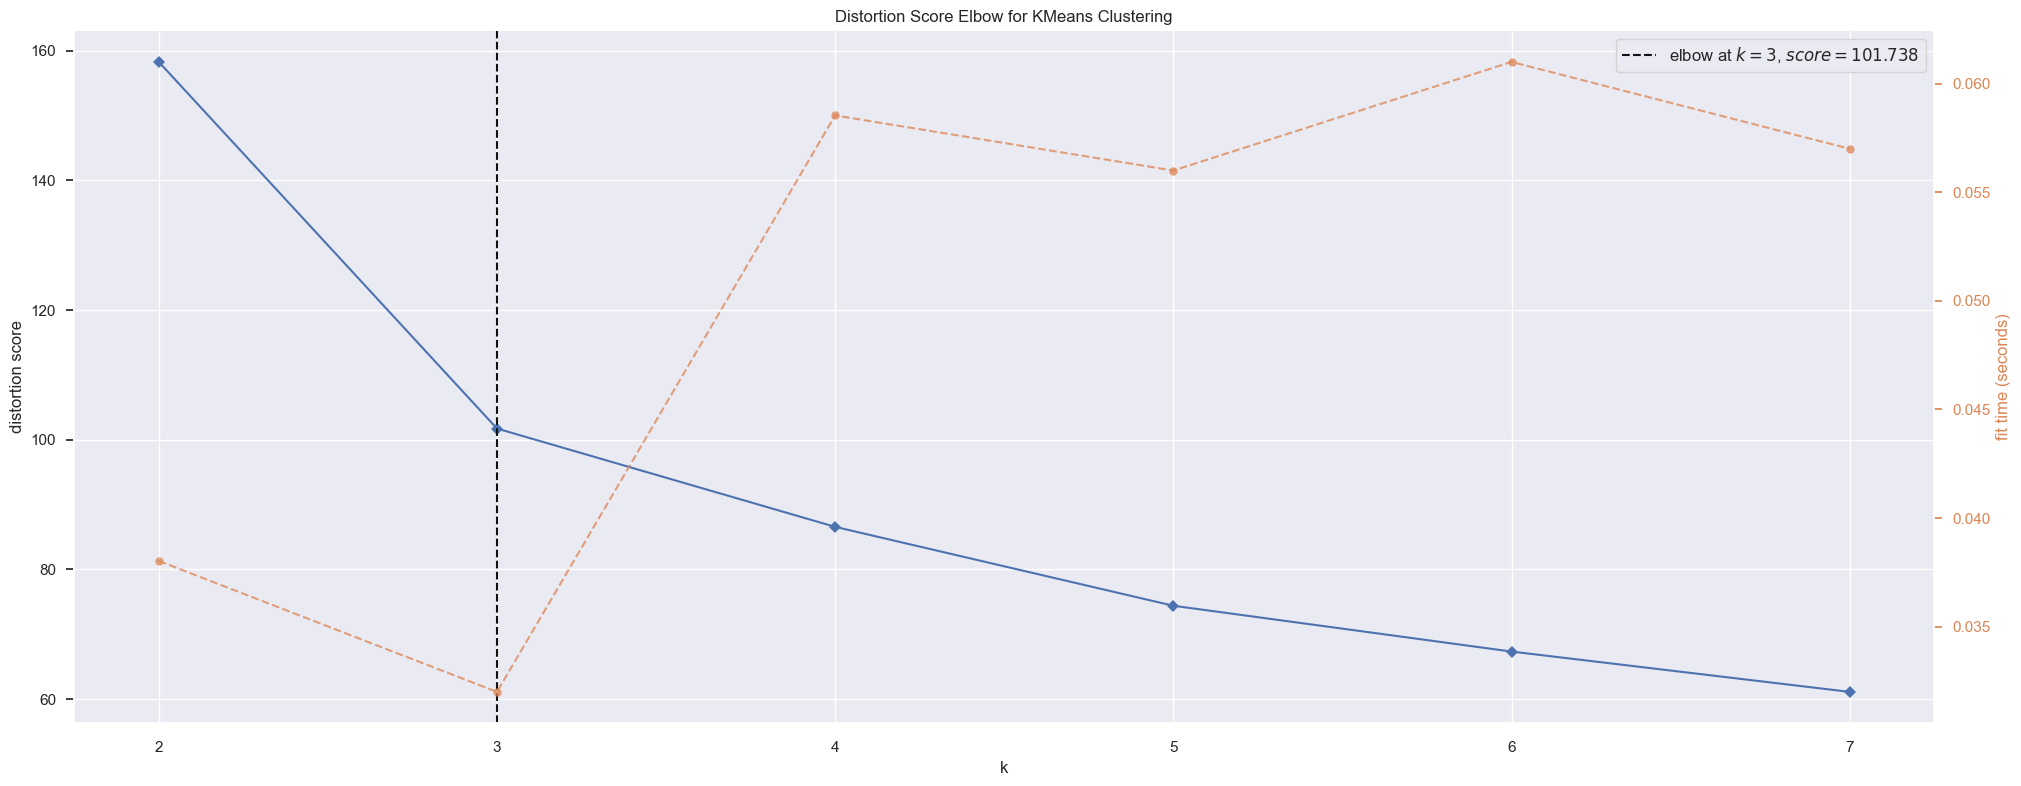

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [159]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timinings=False)
kmeans.fit( X )
kmeans.show()

## 7.2. Sillhouette Score

c:\Users\yvesl\.conda\envs\fidelity_program\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\yvesl\.conda\envs\fidelity_program\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\yvesl\.conda\envs\fidelity_program\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\yvesl\.conda\envs\fidelity_program\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The defa

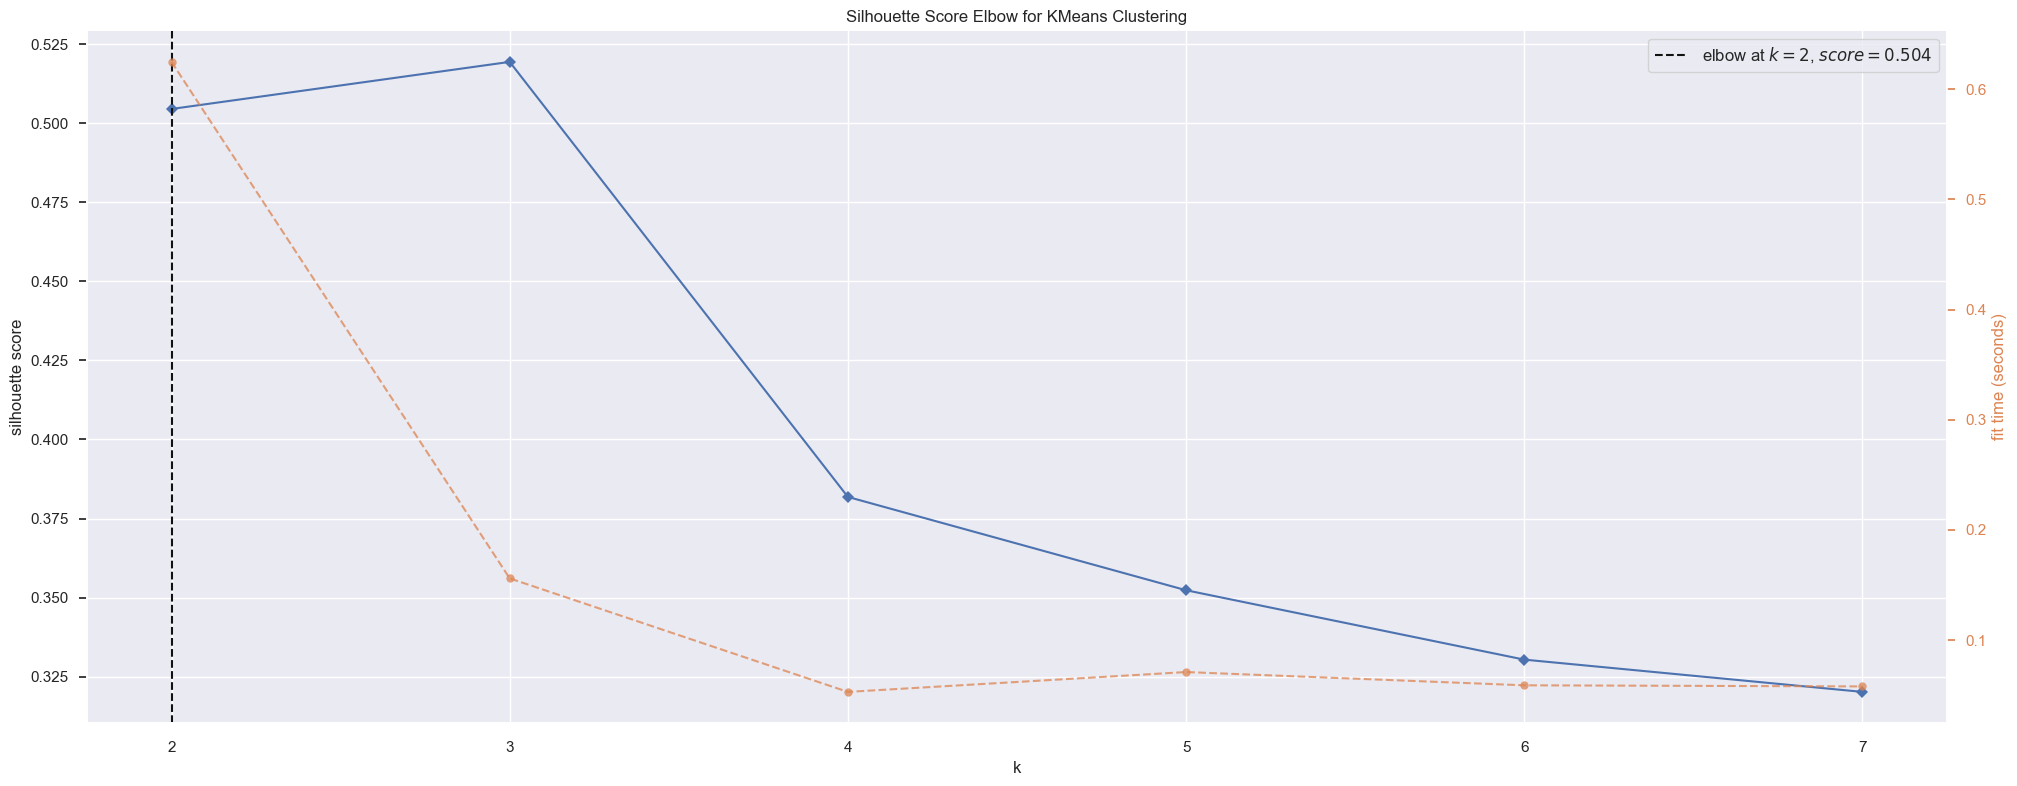

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [160]:
# from yellowbrick.cluster import KElbowVisualizer

kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timinings=False)
kmeans.fit( X )
kmeans.show()
# problema com modulo

## 7.3. Silhouette Analysis

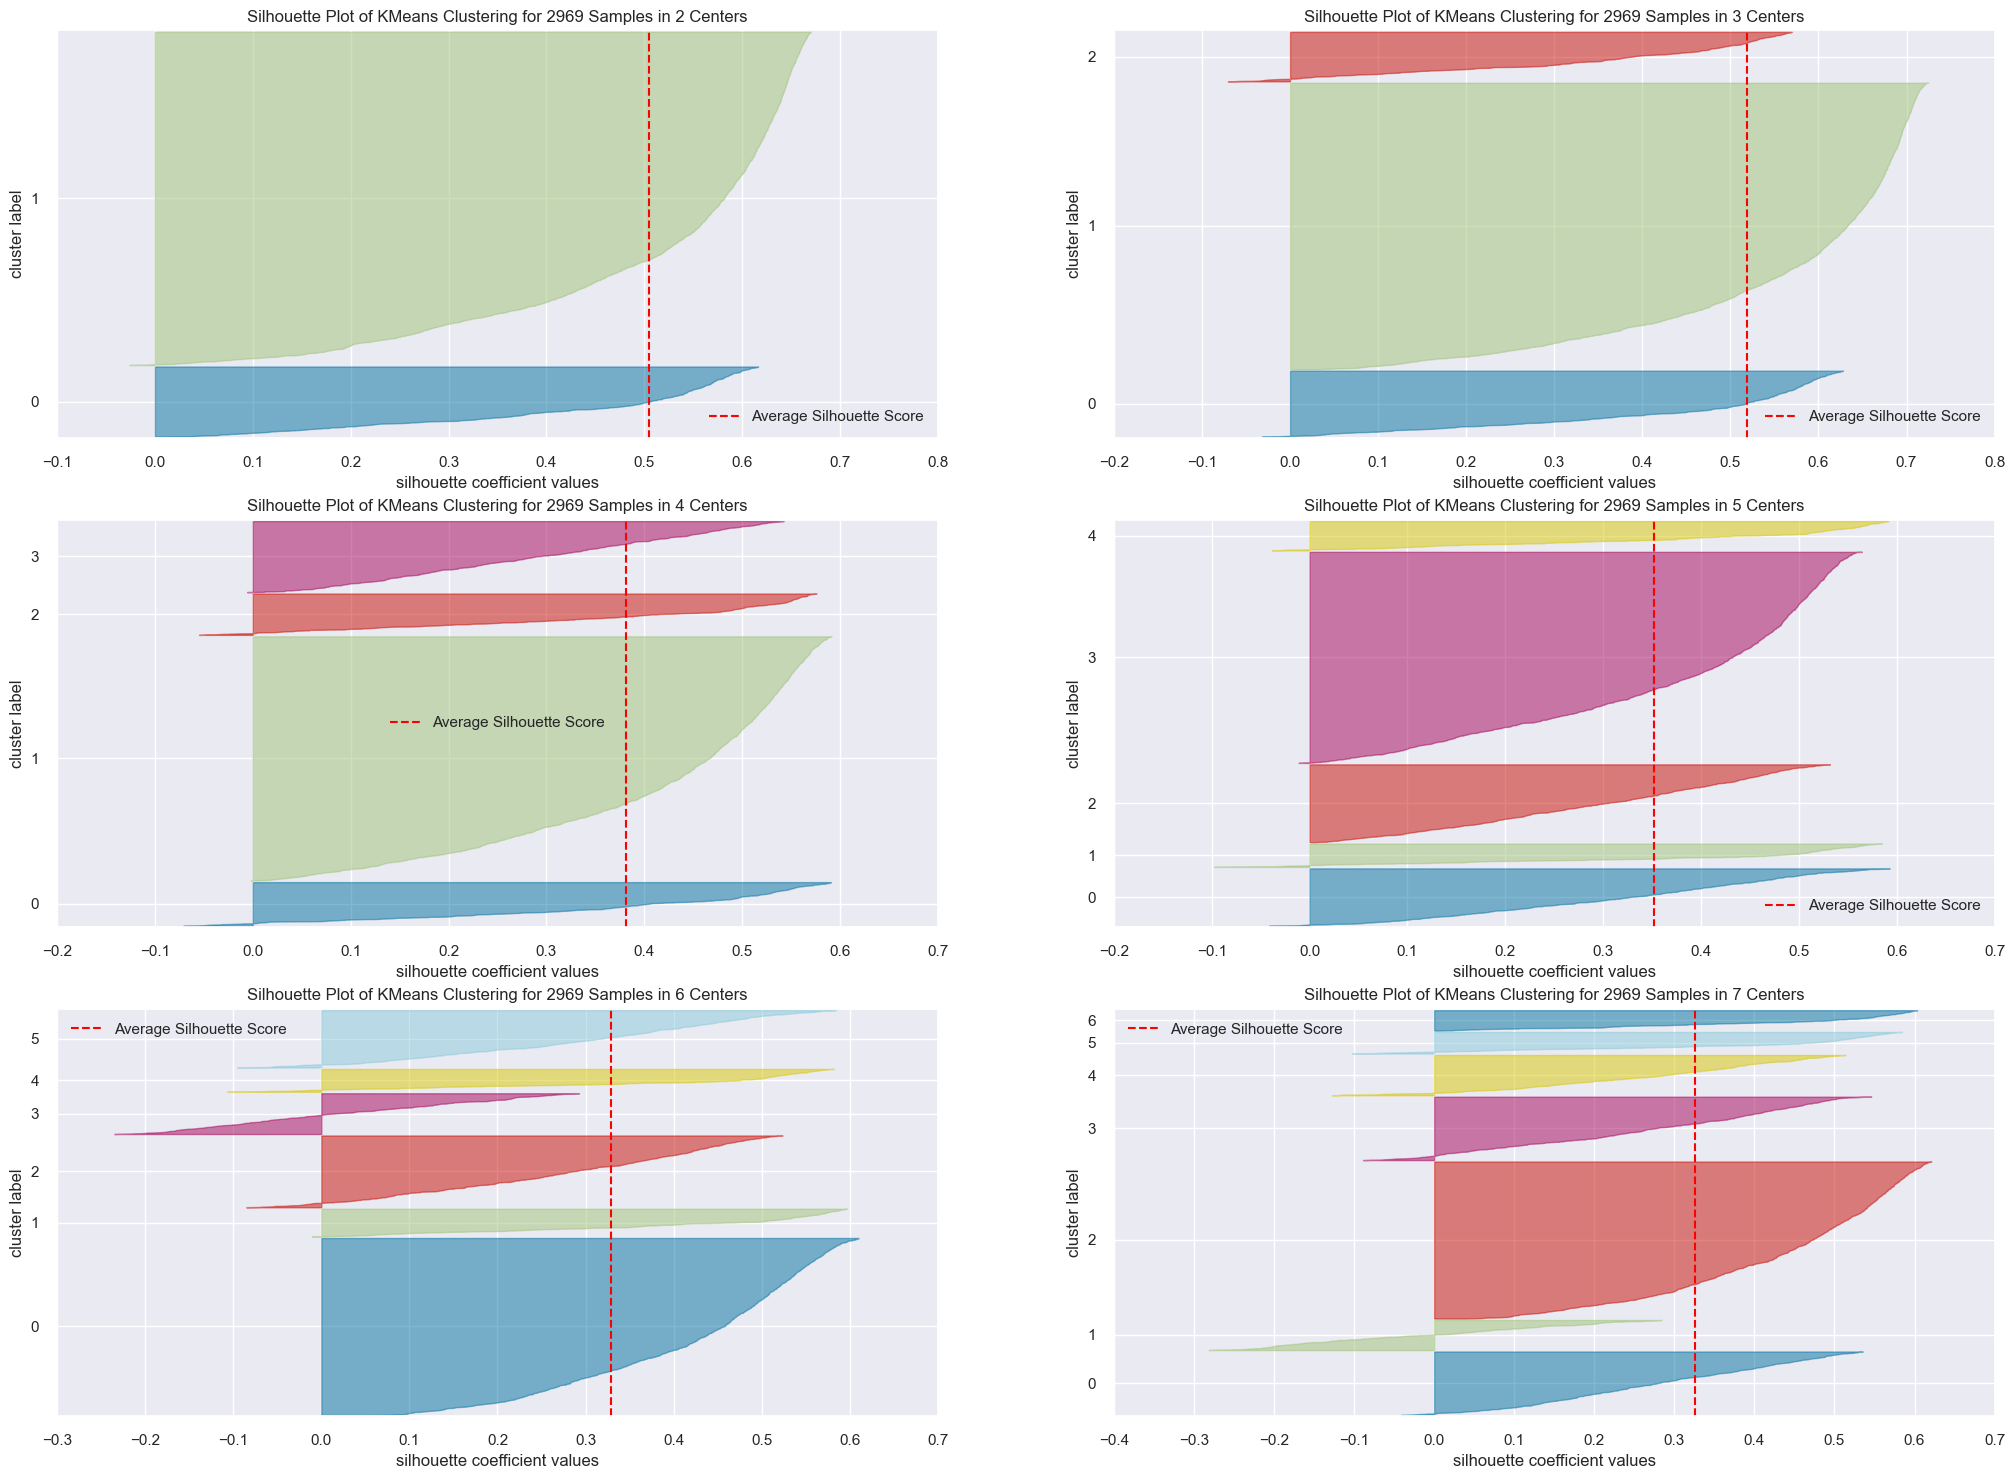

In [161]:
fig, ax = plt.subplots( 3, 2, figsize=(25, 18) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

# <font color='red'> 8.0. Model Training </font>

## 8.1. K-Means

In [162]:
# model definition
k = 4 #valor de cluster do kmeans
kmeans= c.KMeans( init= 'random', n_clusters=k, n_init=10, max_iter=300, random_state=42) # init='random' modo aleatorio porem igual sempre q rodar

#model training 
kmeans.fit( X )

# clustering 
labels = kmeans.labels_

## 8.2. Cluster Validation

In [163]:
## WSS ( Within-cluster sum of square)
print( 'WSS value {}'.format( kmeans.inertia_))

## SS ( Silhouette Score)
print( 'SS value: {}'.format(m.silhouette_score ( X, labels, metric='euclidean')))


WSS value 86.58346478121817
SS value: 0.3818237683023236


# <font color='red'> 9.0. Cluster Analysis </font>

In [164]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

customer_id  gross_revenue  recency_days  qtde_invoices  qtde_item  qtde_products  avg_ticket  avg_recency_days  frequency  qtde_returns  avg_basket_size  avg_unique_basket_size  cluster
0        17850       0.019292      0.997319       0.160976   0.000420       0.011204    0.000285          0.905479   1.000000      0.000494         0.001234                0.025896        2
1        13047       0.011559      0.150134       0.039024   0.001605       0.058263    0.000298          0.928082   0.001345      0.000432         0.003789                0.060260        1
2        12583       0.024000      0.005362       0.068293   0.019347       0.063305    0.000476          0.939212   0.002052      0.000617         0.008252                0.048431        1
3        13748       0.003375      0.254692       0.019512   0.002074       0.012885    0.000565          0.748858   0.000734      0.000000         0.002143                0.015400        3
4        15100       0.003116      0.892761       0.009756   0.000580       0.000000    0.005162          0.979178   0.003985      0.000272         0.000634                0.000000        2

## 9.1. Visualization Inspection

c:\Users\yvesl\.conda\envs\fidelity_program\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


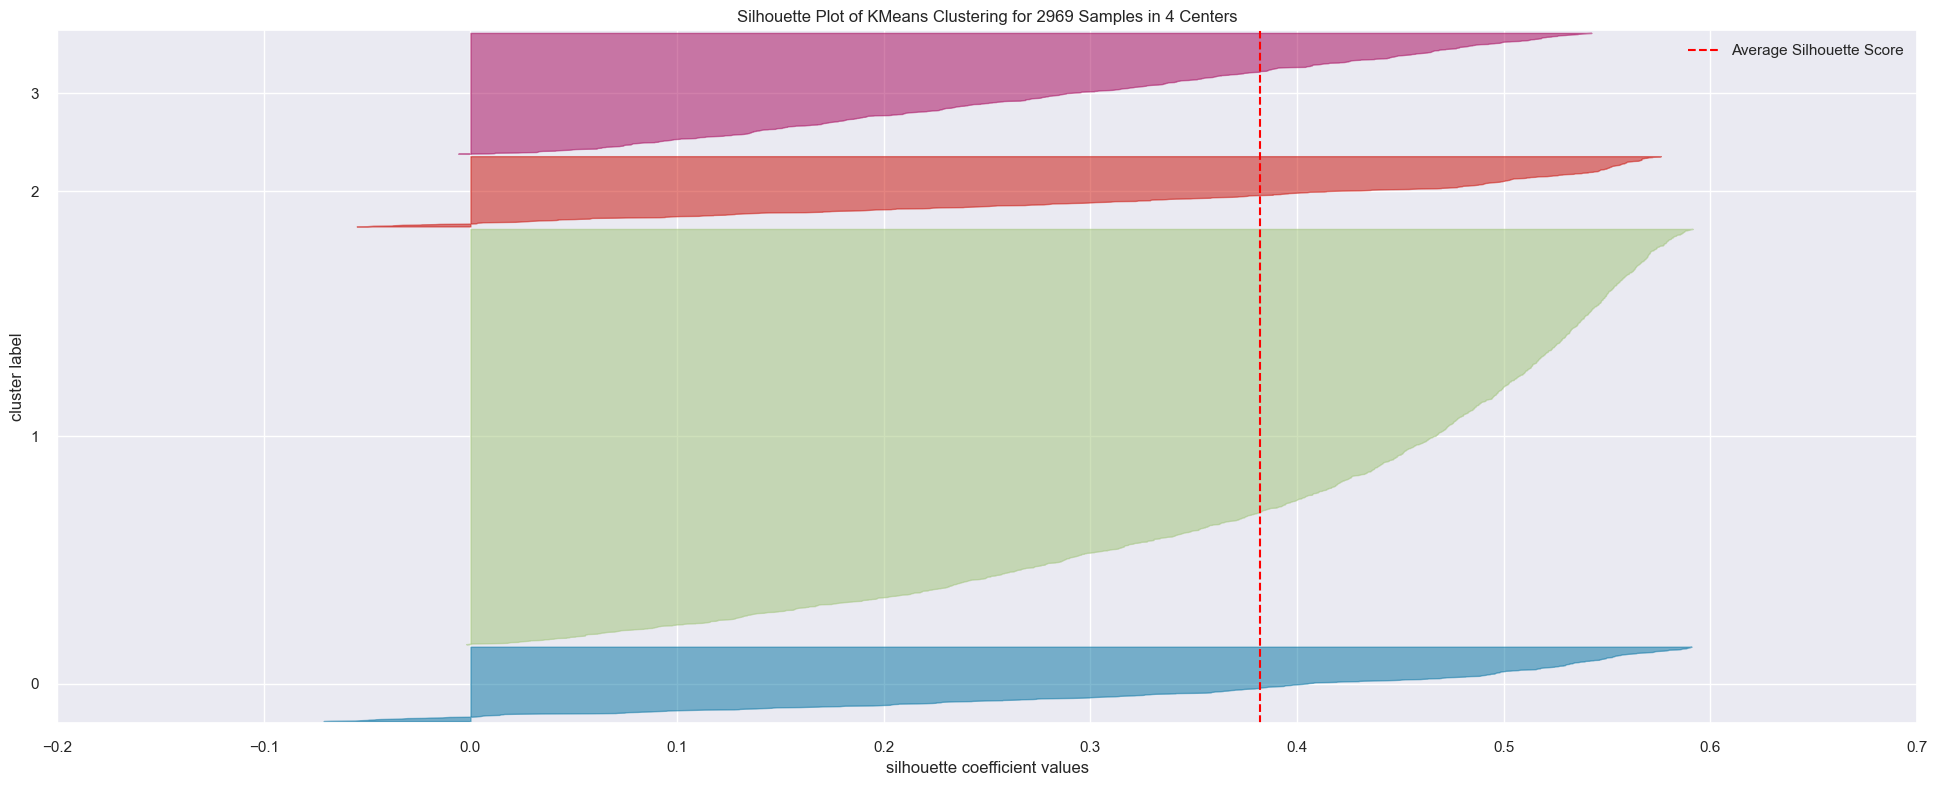

In [165]:
visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
visualizer.fit( X )
visualizer.finalize()

In [166]:
# fig = px.scatter_3d( df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
# fig.show() 

## 9.2. 2d plot

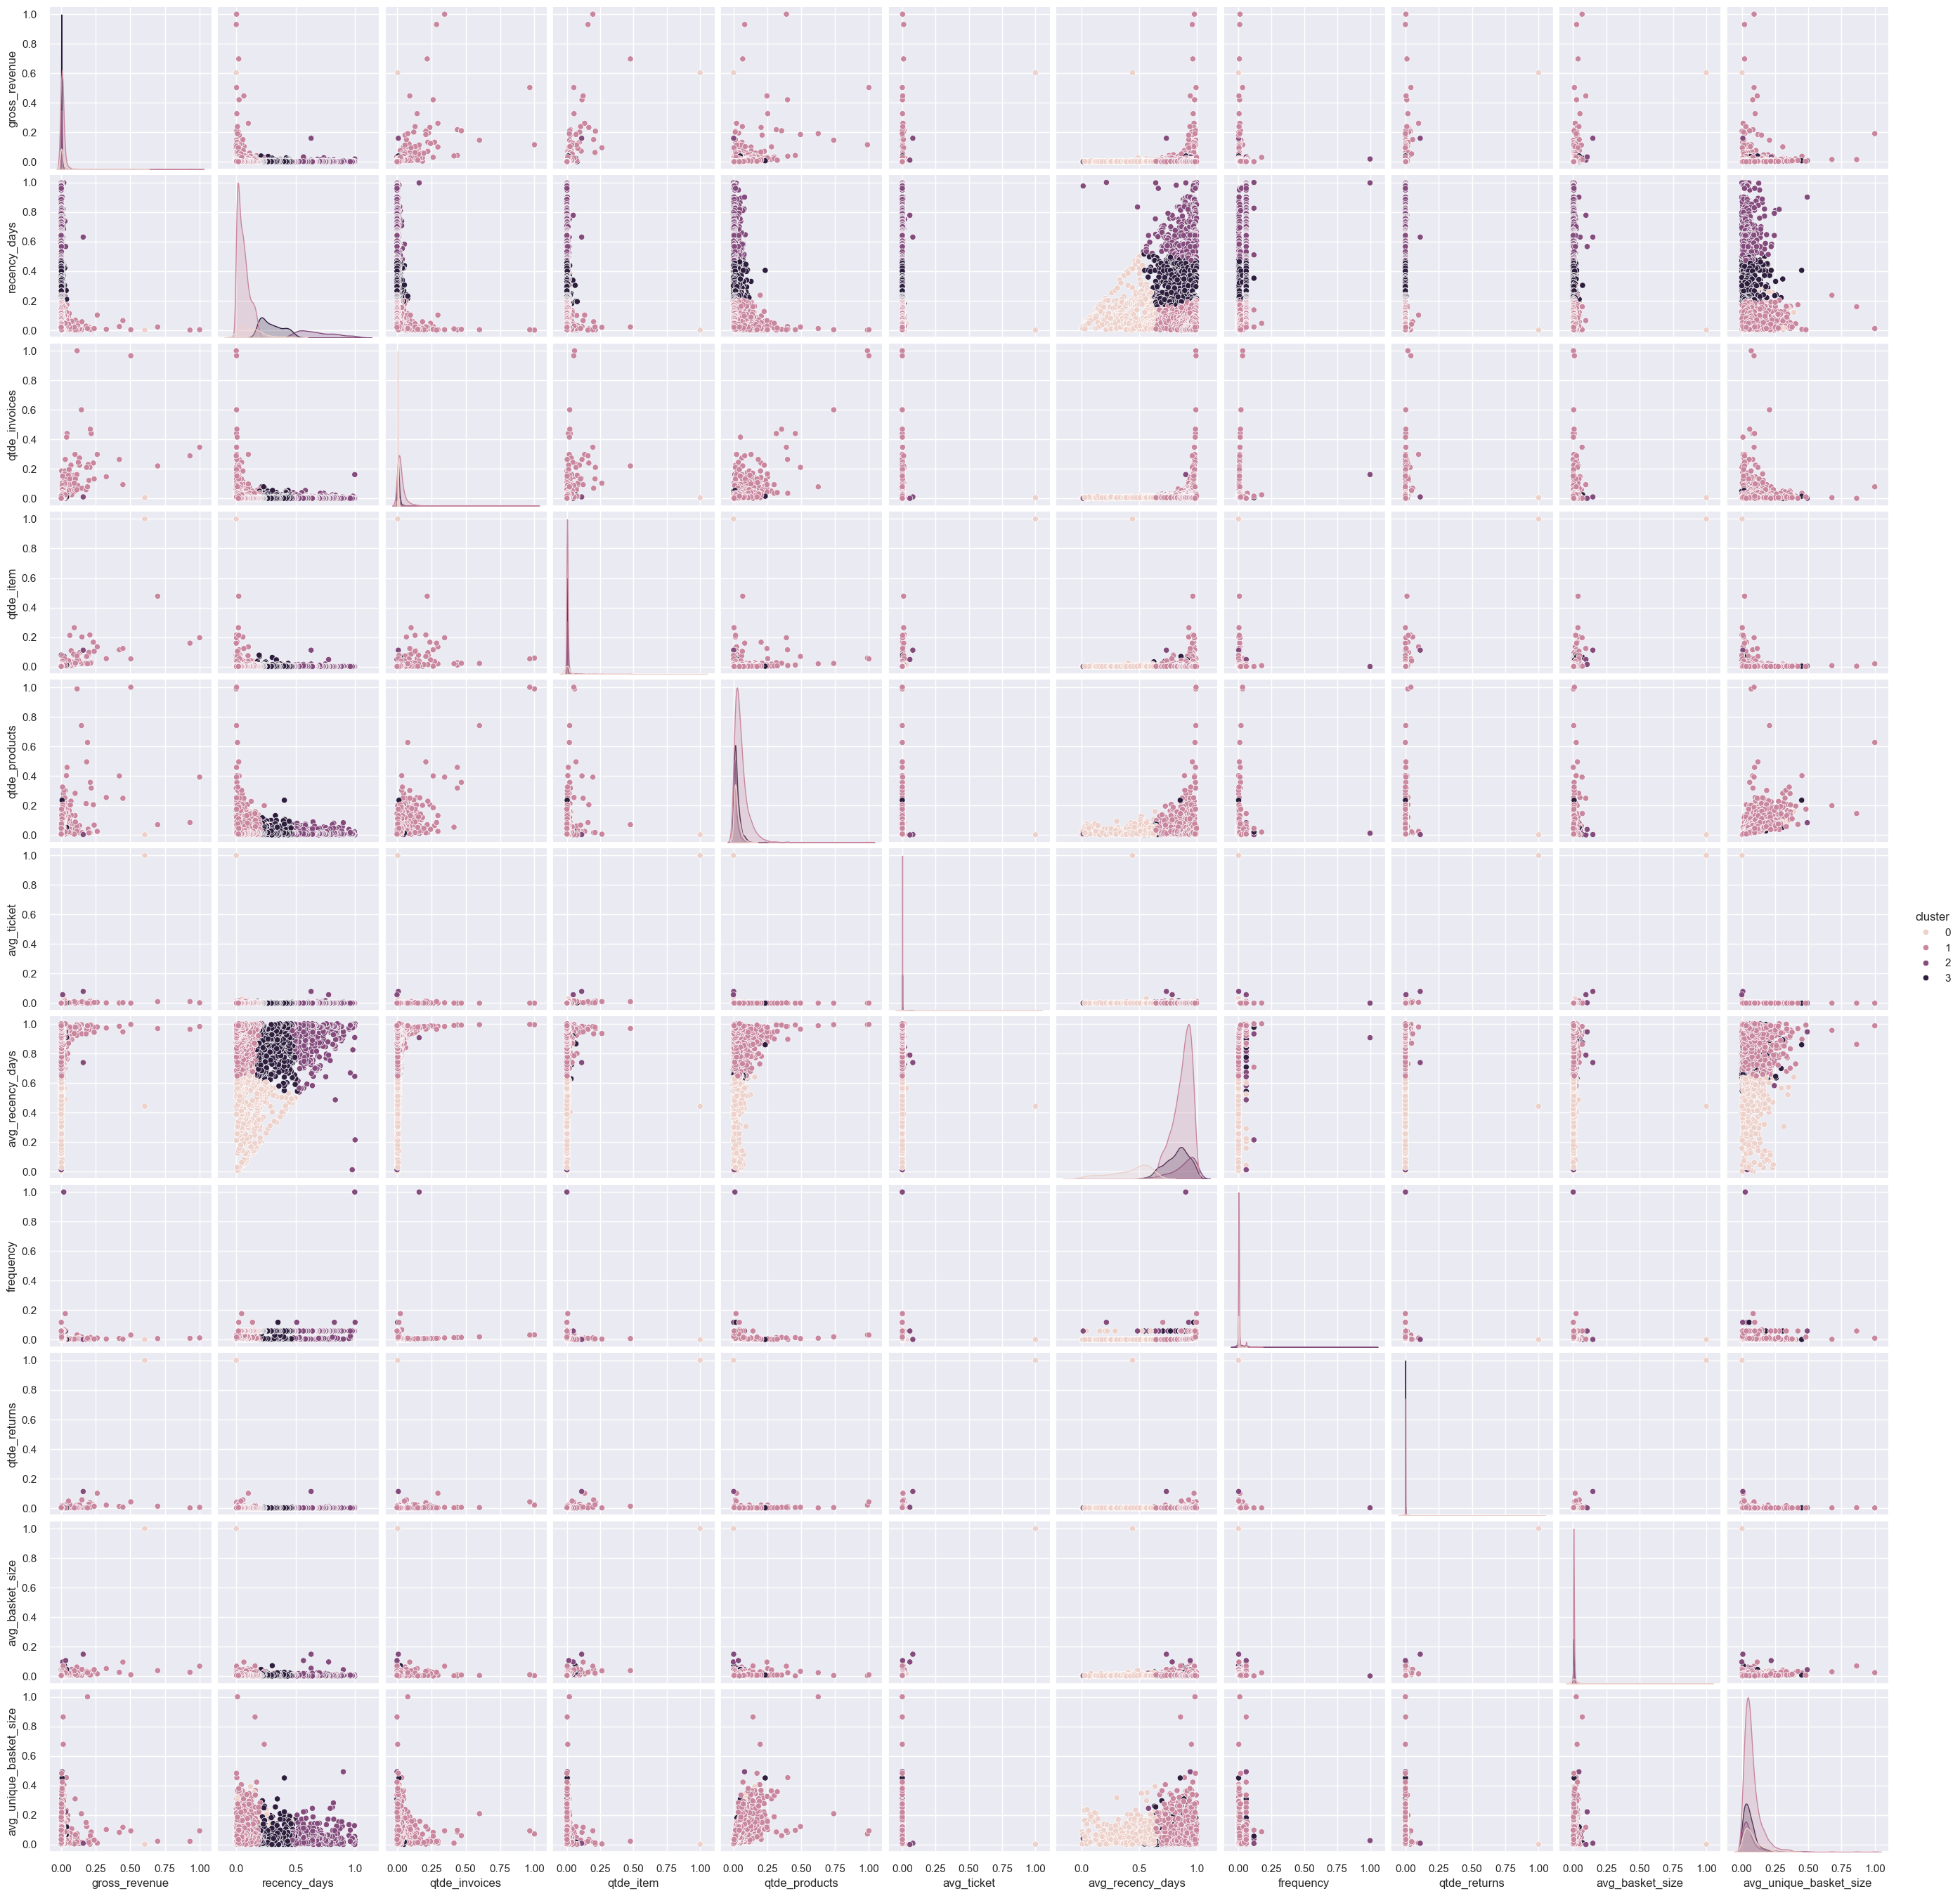

In [167]:
df_viz = df9.drop( columns='customer_id', axis=1)
sns.pairplot( df_viz, hue='cluster')

## 9.3. UMAP


c:\Users\yvesl\.conda\envs\fidelity_program\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

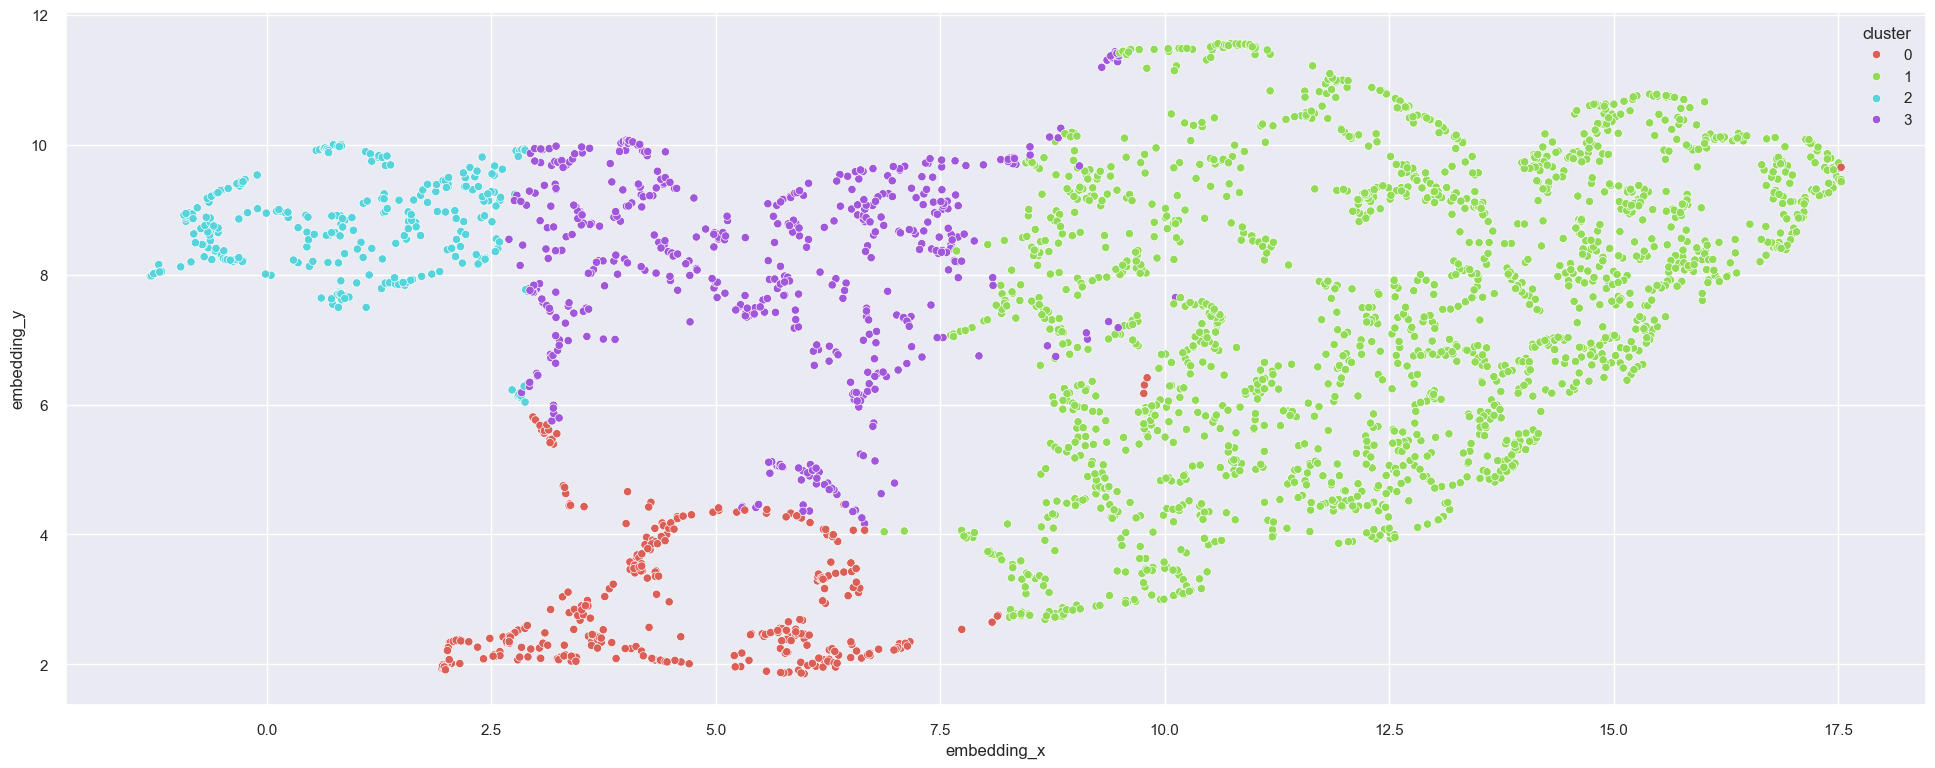

In [168]:
reducer = umap.UMAP( n_neighbors=15,random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz )

## 9.2. Cluster Profle

In [169]:
# Number of customer 
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100* (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross revenue 
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_gross_days = df9[['recency_days', 'cluster']].groupby( 'cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_days, how='inner', on='cluster')

# Avg invoice_no
df_avg_gross_no = df9[['invoice_no', 'cluster']].groupby( 'cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_no, how='inner', on='cluster')

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby( 'cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='cluster')




KeyError: "['invoice_no'] not in index"

In [ ]:
df_cluster.shape

NameError: name 'df_cluster' is not defined

## Cluster 01: ( Candidato à Insider)
    - Número de customers: 6 (0.14% do customers)
    - Recência em média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: 182.182,00 dólares
    
## Cluster 02:
    - Número de customers: 31 (0.71% do customers)
    - Recência em média: 14 dias
    - Compras em média: 53 compras
    - Receita em média: 40.543,00 dólares
    
## Cluster 03:
    - Número de customers: 4.335 (99% do customers)
    - Recência em média: 92 dias
    - Compras em média: 5 compras
    - Receita em média: 1.372,57 dólares
    

# <font color='red'> 10.0. Deploy to Production </font>